# Predictive Modeling
## Weather Prediction
### Regressions, Classification models and ARIMA

In [177]:
# importing packages

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import xgboost as xgb
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn import decomposition
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import norm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.preprocessing import PolynomialFeatures
from sklearn import model_selection, preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from yellowbrick.regressor import ResidualsPlot
sns.set()

## Helper Functions

In [81]:

def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline', linewidth=3)
    plt.plot(model_fpr, model_tpr, 'r', label = 'model', linewidth=3)
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');


In [82]:
def feature_plot(importances, X_train, y_train):
    
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:10]]
    values = importances[indices][:10]

    # Creat the plot
    fig = plt.figure(figsize = (12,8))
    plt.title("Normalized Weights for First Ten Most Predictive Features", fontsize = 16)
    plt.bar(np.arange(10), values, width = 0.6, align="center", color = '#3296c8', \
          label = "Feature Weight") #'#00A000'
    plt.bar(np.arange(10) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#c8dcb4', \
          label = "Cumulative Feature Weight")  #'#0AA0A0' '#96c896'
    plt.xticks(np.arange(10), columns, rotation=45)
    plt.xlim((-0.5, 9.5))
    plt.ylabel("Weight", fontsize = 12)
    plt.xlabel("Feature", fontsize = 12)
    
    plt.legend(loc = 'upper center')
    plt.tight_layout()
    plt.savefig('ROC_XGB.png', dpi=500)
    plt.show()

In [106]:
# helper function for polynomial regression

def create_polynomial_regression_model(degree):
    "Creates a polynomial regression model for the given degree"
    
    poly_features = PolynomialFeatures(degree=degree)
  
  # transforms the existing features to higher degree features.
    X_train_poly = poly_features.fit_transform(X_train)
  
  # fit the transformed features to Linear Regression
    poly_model = LinearRegression()
    poly_model.fit(X_train_poly, Y_train)
  
  # predicting on training data-set
    y_train_predicted = poly_model.predict(X_train_poly)
  
  # predicting on test data-set
    y_test_predict = poly_model.predict(poly_features.fit_transform(X_test))
  
  # evaluating the model on training dataset
    rmse_train = np.sqrt(mean_squared_error(Y_train, y_train_predicted))
    r2_train = r2_score(Y_train, y_train_predicted)
  
  # evaluating the model on test dataset
    rmse_test = np.sqrt(mean_squared_error(Y_test, y_test_predict))
    r2_test = r2_score(Y_test, y_test_predict)
    
    #print("The model performance for the training set")
    #print("-------------------------------------------")
    #print("RMSE of training set is {}".format(rmse_train))
    #print("R2 score of training set is {}".format(r2_train))
  
    #print("\n")
  
    #print("The model performance for the test set")
    #print("------------------------------------------")
    #print("RMSE of test set is {}".format(rmse_test))
    #print("R2 score of test set is {}".format(r2_test))
    


In [104]:
def prediction_plot(x,y):

    plt.figure(figsize=(10,5))
    plt.plot(x.values)
    plt.plot(y)
    plt.title('Prediction')
    plt.ylabel('Temperature [°C]')
    plt.xlabel('Hour')
    labels=('actual','predicted')
    plt.legend(labels)
    plt.show();

In [84]:
## load cleaned weather data

df = pd.read_csv('weather_data_cleaned.csv')
df = df.iloc[:,1:]
df

,MESS_DATUM,ATMO_LBERG,FD_LBERG,FG_LBERG,SD_LBERG,ZENIT,R1,TT_TU,RF_TU,TD,...,V_S1_HHS,P,FF,DD,V_TE005,V_TE010,V_TE020,V_TE050,V_TE100,V_VV
0,2005-01-01 00:01:00,120.0,0.0,0.0,0.0,148.86,0.0,4.7,95.0,4.0,...,90.0,1020.2,2.2,350.0,5.6,5.50,5.20,4.6,5.20,2000.0
1,2005-01-01 01:01:00,100.0,0.0,0.0,0.0,144.98,0.1,4.3,95.0,3.6,...,90.0,1020.5,1.5,310.0,5.3,5.40,5.20,4.6,5.10,3500.0
2,2005-01-01 02:01:00,89.0,0.0,0.0,0.0,138.39,0.0,3.1,96.0,2.5,...,30.0,1021.3,1.5,280.0,4.7,5.10,5.10,4.6,5.10,800.0
3,2005-01-01 06:01:00,113.0,0.0,0.0,0.0,104.08,0.0,2.0,98.0,1.7,...,60.0,1022.0,2.3,220.0,3.7,4.20,4.70,4.8,5.20,3500.0
4,2005-01-01 07:01:00,114.0,0.0,0.0,0.0,96.06,0.0,2.7,100.0,2.7,...,60.0,1021.8,2.8,210.0,3.6,4.00,4.50,4.7,5.20,4500.0
5,2005-01-01 08:01:00,117.0,3.0,3.0,0.0,88.98,0.2,3.7,100.0,3.7,...,60.0,1021.7,3.4,210.0,3.6,4.00,4.50,4.7,5.20,1800.0
6,2005-01-01 09:01:00,116.0,10.0,10.0,0.0,83.19,0.0,4.3,97.0,3.9,...,150.0,1022.1,3.3,220.0,3.8,4.00,4.40,4.8,5.30,4500.0
7,2005-01-01 10:01:00,115.0,23.0,23.0,0.0,79.05,0.0,5.1,93.0,4.0,...,210.0,1021.6,4.3,230.0,4.0,4.00,4.40,4.8,5.30,12000.0
8,2005-01-01 11:01:00,116.0,20.0,20.0,0.0,76.88,0.0,5.3,92.0,4.1,...,210.0,1021.2,4.6,220.0,4.3,4.20,4.40,4.7,5.30,8000.0
9,2005-01-01 12:01:00,113.0,33.0,33.0,1.0,76.88,0.0,5.7,91.0,4.4,...,210.0,1020.4,5.1,230.0,4.6,4.40,4.40,4.7,5.30,8000.0


## Target variable: TEMPERATURE

In [9]:
## Linear Regression for temperature with all variables to look on the significance

model = 'TT_TU ~ ATMO_LBERG + FD_LBERG + FG_LBERG + SD_LBERG + ZENIT + R1 + RF_TU + TD + V_N + V_S1_CS + V_S1_HHS + P + FF + DD + V_TE005 + V_TE010 + V_TE020 + V_TE050 + V_TE100 + V_VV'
smf.ols(formula=model, data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  TT_TU   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 1.224e+06
Date:                Tue, 17 Dec 2019   Prob (F-statistic):               0.00
Time:                        13:59:48   Log-Likelihood:            -1.0993e+05
No. Observations:              134437   AIC:                         2.199e+05
Df Residuals:                  134416   BIC:                         2.201e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     23.4564      0.179    131.291      0.000      23.106      23.807
ATMO_LBERG     0.0075      0.000     48.798      0.000       0.007       0.008
FD_LBERG      -0.0074    9.7e-05    -76.617      0.000      -0.008      -0.007
FG_LBERG       0.0017    7.2e-05     23.200      0.000       0.002       0.002
SD_LBERG       0.0026      0.000     18.315      0.000       0.002       0.003
ZENIT          0.0038   9.19e-05     40.812      0.000       0.004       0.004
R1             0.0314      0.003      9.592      0.000       0.025       0.038
RF_TU         -0.2020      0.000   -852.053      0.000      -0.202      -0.202
TD             0.9293      0.001   1237.356      0.000       0.928       0.931
V_N           -0.0157      0.001    -17.450      0.000      -0.017      -0.014
V_S1_CS        0.0068      0.002      3.887      0.000       0.003       0.010
V_S1_HHS    2.162e-05   2.03e-06     10.650      0.000    1.76e-05    2.56e-05
P             -0.0047      0.000    -27.880      0.000      -0.005      -0.004
FF            -0.0366      0.001    -43.301      0.000      -0.038      -0.035
DD            -0.0002   1.71e-05    -11.175      0.000      -0.000      -0.000
V_TE005        0.1959      0.005     36.945      0.000       0.185       0.206
V_TE010        0.0408      0.012      3.488      0.000       0.018       0.064
V_TE020       -0.2482      0.011    -22.614      0.000      -0.270      -0.227
V_TE050        0.1285      0.007     19.408      0.000       0.115       0.141
V_TE100       -0.0314      0.003    -11.274      0.000      -0.037      -0.026
V_VV       -1.001e-05   1.61e-07    -62.290      0.000   -1.03e-05    -9.7e-06
==============================================================================
Omnibus:                    82390.385   Durbin-Watson:                   0.232
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2271358.910
Skew:                           2.483   Prob(JB):                         0.00
Kurtosis:                      22.515   Cond. No.                     3.29e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.29e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [10]:
corr = df.corr()
corr
best_corr = corr.TT_TU[abs(corr.TT_TU) > 0.3]
best_corr


ATMO_LBERG    0.581527
FD_LBERG      0.412200
FG_LBERG      0.478398
SD_LBERG      0.377009
ZENIT        -0.518277
TT_TU         1.000000
RF_TU        -0.520045
TD            0.867519
V_TE005       0.951536
V_TE010       0.932807
V_TE020       0.894471
V_TE050       0.848419
V_TE100       0.805383
V_VV          0.393779
Name: TT_TU, dtype: float64

In [11]:
## Linear Regression with best correlated and most significant variables
## dropping dew point because it contains information about temperature and soil temperatures 

model = 'TT_TU ~ ATMO_LBERG + FD_LBERG + FG_LBERG + ZENIT + RF_TU + V_VV + C(V_N)'
smf.ols(formula=model, data=df).fit().summary()

## best prediction with solar data, zenith angle of sun, relative humidity, visibility and cloud coverage 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  TT_TU   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                 2.192e+04
Date:                Tue, 17 Dec 2019   Prob (F-statistic):               0.00
Time:                        13:59:51   Log-Likelihood:            -3.8025e+05
No. Observations:              134437   AIC:                         7.605e+05
Df Residuals:                  134422   BIC:                         7.607e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -12.4269      0.159    -78.372      0.000     -12.738     -12.116
C(V_N)[T.1.0]     0.2280      0.062      3.673      0.000       0.106       0.350
C(V_N)[T.2.0]     0.1867      0.066      2.849      0.004       0.058       0.315
C(V_N)[T.3.0]    -0.2209      0.066     -3.355      0.001      -0.350      -0.092
C(V_N)[T.4.0]    -0.7501      0.069    -10.816      0.000      -0.886      -0.614
C(V_N)[T.5.0]    -1.0701      0.067    -16.057      0.000      -1.201      -0.940
C(V_N)[T.6.0]    -1.6181      0.064    -25.392      0.000      -1.743      -1.493
C(V_N)[T.7.0]    -3.4567      0.056    -61.640      0.000      -3.567      -3.347
C(V_N)[T.8.0]    -5.4184      0.059    -92.358      0.000      -5.533      -5.303
ATMO_LBERG        0.3038      0.001    374.954      0.000       0.302       0.305
FD_LBERG         -0.0235      0.001    -33.357      0.000      -0.025      -0.022
FG_LBERG          0.0123      0.000     36.631      0.000       0.012       0.013
ZENIT            -0.0488      0.001    -76.902      0.000      -0.050      -0.048
RF_TU            -0.0834      0.001    -75.134      0.000      -0.086      -0.081
V_VV           6.419e-05   1.14e-06     56.450      0.000     6.2e-05    6.64e-05
==============================================================================
Omnibus:                    20498.704   Durbin-Watson:                   0.104
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            61787.208
Skew:                           0.804   Prob(JB):                         0.00
Kurtosis:                       5.906   Cond. No.                     4.12e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.12e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Linear Regression with sklearn

In [182]:
## linear regression for temperature with sklearn

X = df[['ATMO_LBERG', 'FD_LBERG', 'FG_LBERG', 'ZENIT', 'V_VV', 'V_N']]
Y = df.TT_TU 

#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.01, random_state=0)

X_train = X[:-48]
X_test = X[-48:-24]
Y_train = Y[:-48]
Y_test = Y[-48:-24]

lin_model = LinearRegression()
lin_model.fit(X_train, Y_train)

y_pred = lin_model.predict(X_test)

# Metrics
mae0 = mean_absolute_error(Y_test.values.ravel(), y_pred)
rmse0 = np.sqrt(mean_squared_error(Y_test.values.ravel(), y_pred))
r2 = r2_score(Y_test.values.ravel(), y_pred)

# Print metrics
print('Mean Absolute Error:', round(mae0, 2))
print('Mean Squared Error:', round(rmse0, 2))
print('R-squared scores:', round(r2, 2))

Mean Absolute Error: 2.98
Mean Squared Error: 3.41
R-squared scores: -0.0


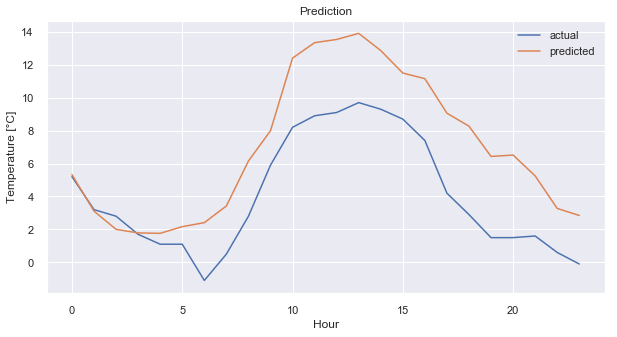

In [183]:
prediction_plot(Y_test, y_pred)

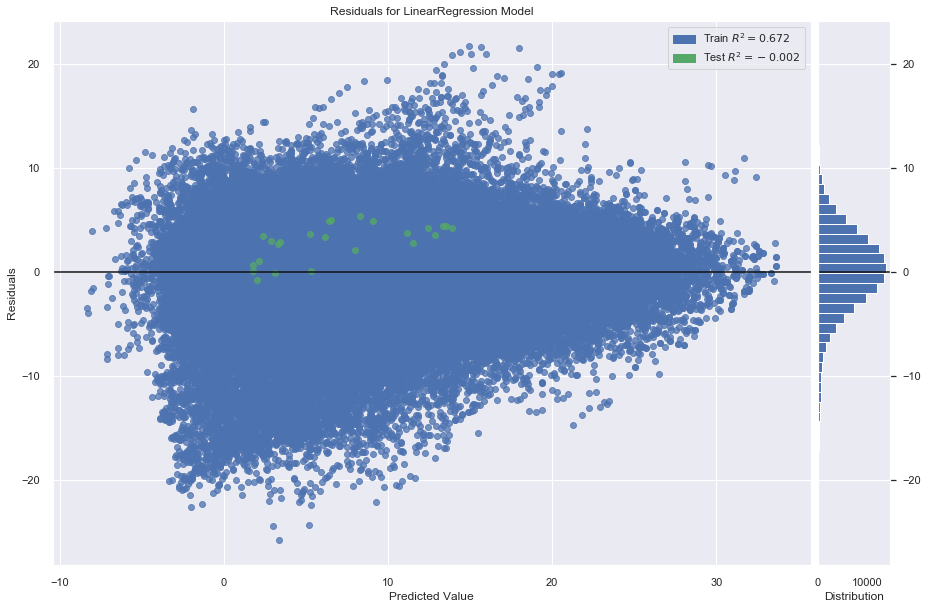

In [184]:

visualizer = ResidualsPlot(lin_model, size=(1080,720))
visualizer.fit(X_train, Y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, Y_test)  # Evaluate the model on the test data
visualizer.show();          

## Polynomial Regression

Degree: 1 R2 -0.001674224379448308 RMSE 3.4104995493576418


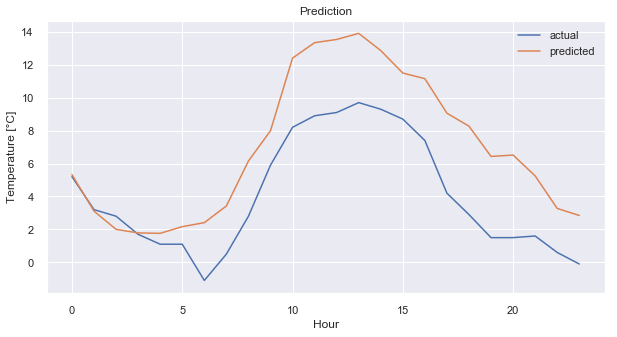

Degree: 2 R2 0.663443775337034 RMSE 1.9768948085693392


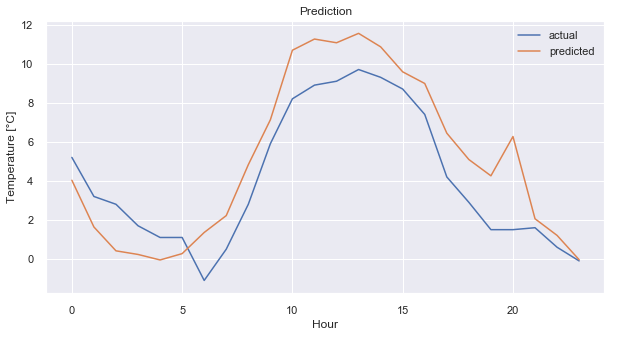

In [185]:
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 24/df.shape[0], random_state=0)

X_train = X[:-48]
X_test = X[-48:-24]
Y_train = Y[:-48]
Y_test = Y[-48:-24]

performance_temperature1 = []
performance_temperature2 = []
for i in range(1,3,1):
    
    poly_features = PolynomialFeatures(degree=i)
  
  # transforms the existing features to higher degree features.
    X_train_poly = poly_features.fit_transform(X_train)
  
  # fit the transformed features to Linear Regression
    poly_model = LinearRegression()
    poly_model.fit(X_train_poly, Y_train)
  
  # predicting on training data-set
    y_train_predicted = poly_model.predict(X_train_poly)
  
  # predicting on test data-set
    y_test_predict = poly_model.predict(poly_features.fit_transform(X_test))
  
  # evaluating the model on training dataset
    rmse_train = np.sqrt(mean_squared_error(Y_train, y_train_predicted))
    r2_train = r2_score(Y_train, y_train_predicted)
  
  # evaluating the model on test dataset
    rmse_test = np.sqrt(mean_squared_error(Y_test, y_test_predict))
    r2_test = r2_score(Y_test, y_test_predict)
    performance_temperature1.append(r2_test)
    performance_temperature2.append(rmse_test)
    print("Degree: {}".format(i),"R2 {}".format(performance_temperature1[-1]), "RMSE {}".format(performance_temperature2[-1]))
    
    prediction_plot(Y_test,y_test_predict)

## GradientBoostingRegressor

In [113]:
from sklearn.ensemble import GradientBoostingRegressor
# Set lower and upper quantile
LOWER_ALPHA = 0.1
UPPER_ALPHA = 0.9
# Each model has to be separate
lower_model = GradientBoostingRegressor(loss="quantile", alpha=LOWER_ALPHA, learning_rate=1) #, n_estimators=500)
# The mid model will use the default loss
mid_model = GradientBoostingRegressor(loss="ls",learning_rate=1)#, n_estimators=500)
upper_model = GradientBoostingRegressor(loss="quantile", alpha=UPPER_ALPHA, learning_rate=1)#, n_estimators=500)

X_train = X[:-48]
X_test = X[-48:-24]
Y_train = Y[:-48]
Y_test = Y[-48:-24]

# Fit models
lower_model.fit(X_train, Y_train)
mid_model.fit(X_train, Y_train)
upper_model.fit(X_train, Y_train)

# Record actual values on test set
predictions = pd.DataFrame(Y_test)
# Predict
predictions['lower'] = lower_model.predict(X_test)
predictions['mid'] = mid_model.predict(X_test)
predictions['upper'] = upper_model.predict(X_test)

In [114]:
predictions.head()

,TT_TU,lower,mid,upper
134389,5.2,-0.7,4.226921,6.4
134390,3.2,-0.2,2.949617,5.6
134391,2.8,-3.6,2.013111,4.9
134392,1.7,-3.1,-0.240908,3.2
134393,1.1,-9.6,0.046931,4.2


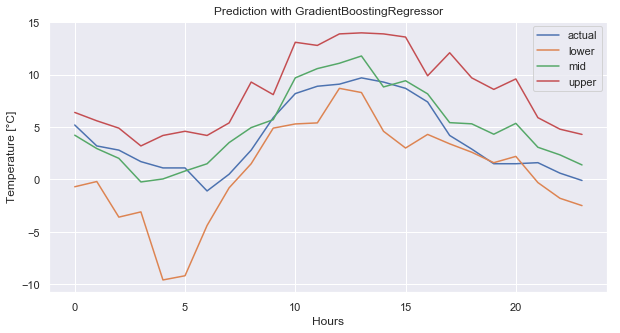

In [117]:
plt.figure(figsize=(10,5))
plt.plot(predictions.values)
#plt.plot(predictions.TT_TU.values,linewidth=4)
labels=('actual','lower','mid','upper')
plt.legend(labels)
plt.title('Prediction with GradientBoostingRegressor')
plt.xlabel('Hours')
plt.ylabel('Temperature [°C]');

In [123]:
predictions['mid_dev_abs'] = abs(predictions.TT_TU-predictions.mid)
predictions['mid_r2'] = r2_score(predictions.TT_TU, predictions.mid)
predictions['lower_dev_abs'] = abs(predictions.TT_TU-predictions.lower)
predictions['lower_r2'] = r2_score(predictions.TT_TU, predictions.lower)
predictions['upper_dev_abs'] = abs(predictions.TT_TU-predictions.upper)
predictions['upper_r2'] = r2_score(predictions.TT_TU, predictions.upper)

print('RMSE:',predictions.lower_dev_abs.mean(),predictions.mid_dev_abs.mean(),predictions.upper_dev_abs.mean())
print('R2:', predictions.lower_r2.mean(),predictions.mid_r2.mean(),predictions.upper_r2.mean())

RMSE: 3.2791666666664376 1.5632035825629746 4.391666666638034
R2: -0.6130850483275934 0.7148219979352558 -0.9636184225124835


## AdaBoostRegressor

In [139]:
X_train = X[:-48]
X_test = X[-48:-24]
Y_train = Y[:-48]
Y_test = Y[-48:-24]

from sklearn.ensemble import AdaBoostRegressor

regr = AdaBoostRegressor(random_state=0, n_estimators=500, learning_rate=0.3)
regr.fit(X_train, Y_train)
regr.feature_importances_
y_pred = regr.predict(X_test)

In [140]:
#del test
y_pred=pd.DataFrame(y_pred)
y_pred
test = pd.concat([y_pred,Y_test.reset_index()],axis=1)
test.drop(columns='index',inplace=True)


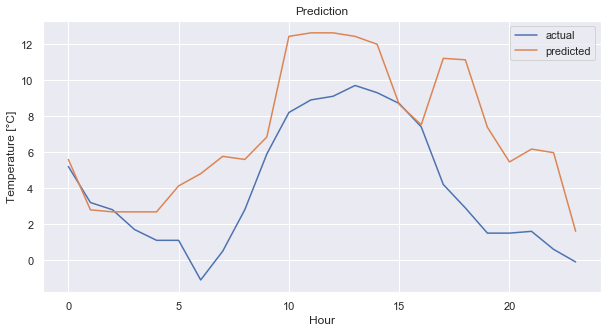

In [141]:
prediction_plot(Y_test,y_pred)

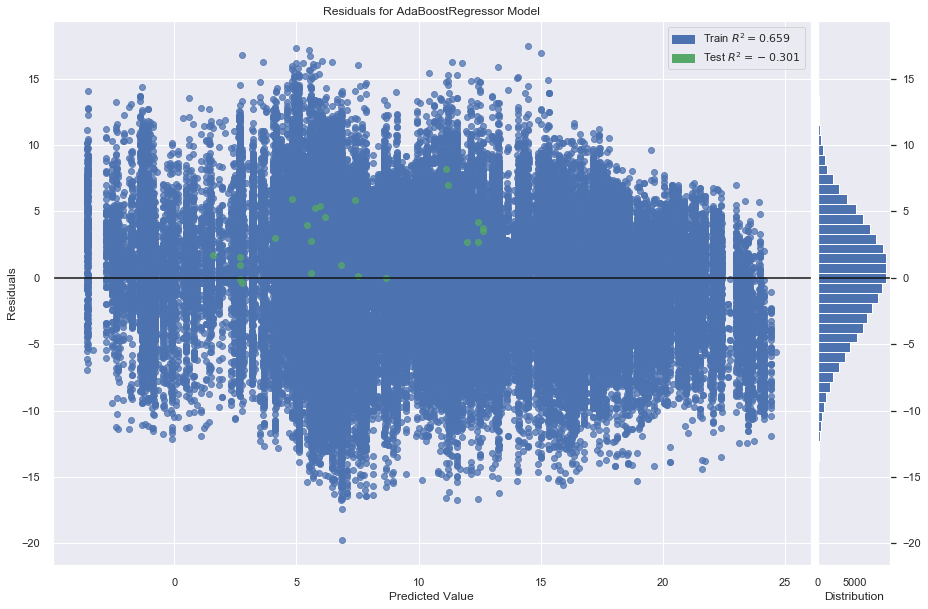

In [188]:
visualizer = ResidualsPlot(regr, size=(1080,720))
visualizer.fit(X_train, Y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, Y_test)  # Evaluate the model on the test data
visualizer.show(); 

In [142]:
# Metrics
mae0 = mean_absolute_error(Y_test.values.ravel(), y_pred)
rmse0 = np.sqrt(mean_squared_error(Y_test.values.ravel(), y_pred))
r2 = r2_score(Y_test.values, y_pred)

# Print metrics
print('Mean Absolute Error:', round(mae0, 2))
print('RMSE:', round(rmse0, 2))
print('R2:', round(r2, 2))

Mean Absolute Error: 3.13
RMSE: 3.89
R2: -0.3


## Random-Forest-Regressor

In [144]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error

In [145]:
X = df[['ATMO_LBERG', 'FD_LBERG', 'FG_LBERG', 'ZENIT', 'V_VV', 'V_N']]
Y = df.TT_TU

#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 24/df.shape[0], random_state=0)

X_train = X[:-48]
X_test = X[-48:-24]
Y_train = Y[:-48]
Y_test = Y[-48:-24]

rf = RandomForestRegressor(n_estimators = 1000, random_state = 0)

# Train the model on training data
rf.fit(X_train, Y_train)

# Use the forest's predict method on the test data
Y_pred = rf.predict(X_test)

In [146]:
# Metrics
mae0 = mean_absolute_error(Y_test.values.ravel(), Y_pred)
rmse0 = np.sqrt(mean_squared_error(Y_test.values.ravel(), Y_pred))
r2 = r2_score(Y_test.values.ravel(), Y_pred)

# Print metrics
print('Mean Absolute Error:', round(mae0, 2))
print('RMSE:', round(rmse0, 2))
print('R2:', round(r2, 2))

Mean Absolute Error: 1.69
RMSE: 1.97
R-squared scores: 0.66


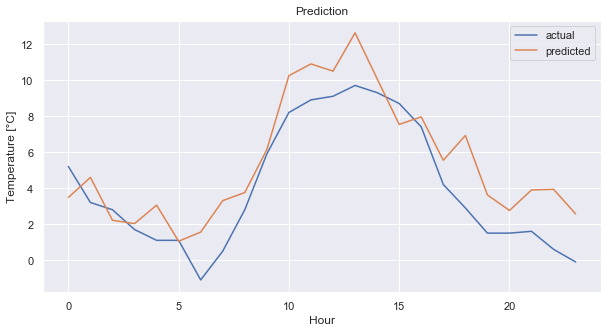

In [147]:
prediction_plot(Y_test, Y_pred)

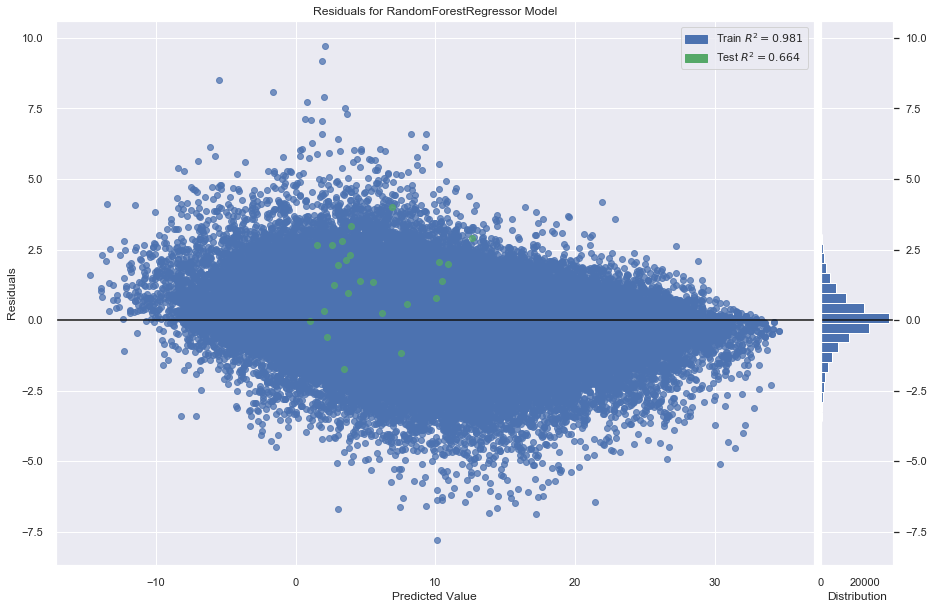

In [189]:
visualizer = ResidualsPlot(rf, size=(1080,720))
visualizer.fit(X_train, Y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, Y_test)  # Evaluate the model on the test data
visualizer.show(); 

In [148]:
## Feature importances :

feature_list = X.columns

# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: ATMO_LBERG           Importance: 0.52
Variable: ZENIT                Importance: 0.2
Variable: V_N                  Importance: 0.16
Variable: V_VV                 Importance: 0.06
Variable: FG_LBERG             Importance: 0.04
Variable: FD_LBERG             Importance: 0.02


## XGBoost Regressor

In [190]:
import xgboost as xgb

X_train = X[:-48]
X_test = X[-48:-24]
Y_train = Y[:-48]
Y_test = Y[-48:-24]

model = xgb.XGBRegressor(n_estimators=500,learning_rate=0.1)
model.fit(X_train,Y_train)

#Prediction
Y_pred = model.predict(data=X_test)

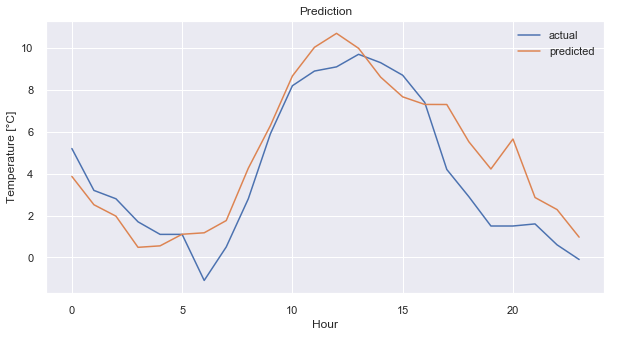

In [191]:
prediction_plot(Y_test, Y_pred)

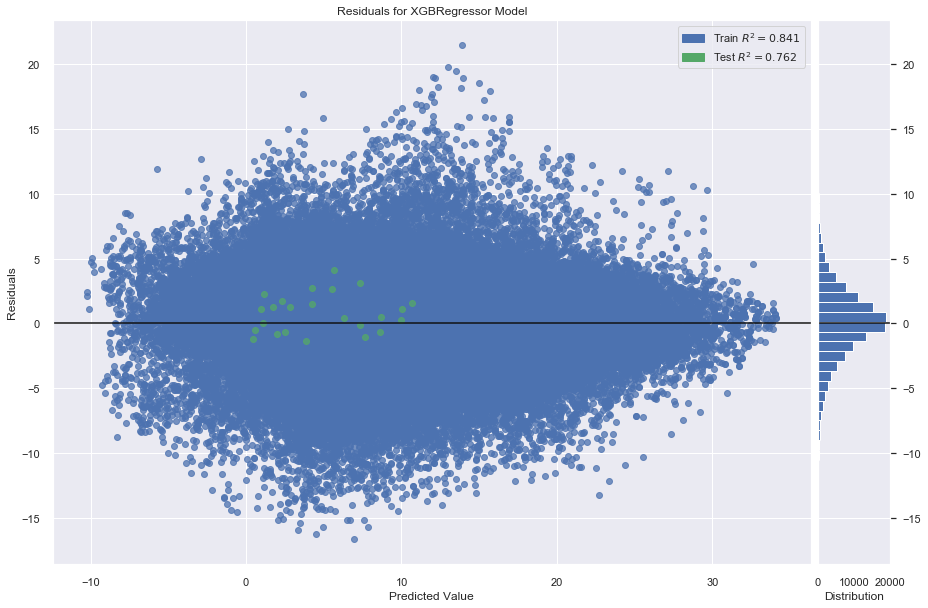

In [192]:
visualizer = ResidualsPlot(model, size=(1080,720))
visualizer.fit(X_train, Y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, Y_test)  # Evaluate the model on the test data
visualizer.show(); 

In [193]:
# Metrics
mae0 = mean_absolute_error(Y_test.values.ravel(), Y_pred)
rmse0 = np.sqrt(mean_squared_error(Y_test.values.ravel(), Y_pred))
r2 = r2_score(Y_test.values.ravel(), Y_pred)

# Print metrics
print('Mean Absolute Error:', round(mae0, 2))
print('RMSE:', round(rmse0, 2))
print('R2:', round(r2, 2))

Mean Absolute Error: 1.33
RMSE: 1.66
R2: 0.76


## KNeighborsRegressor

In [194]:
from sklearn.neighbors import KNeighborsRegressor

X = df[['ATMO_LBERG', 'FD_LBERG', 'FG_LBERG', 'ZENIT', 'V_VV', 'V_N']]
Y = df.TT_TU

X_train = X[:-48]
X_test = X[-48:-24]
Y_train = Y[:-48]
Y_test = Y[-48:-24]

knr = KNeighborsRegressor(n_neighbors=60)
knr.fit(X_train, Y_train)
Y_pred = knr.predict(X_test)

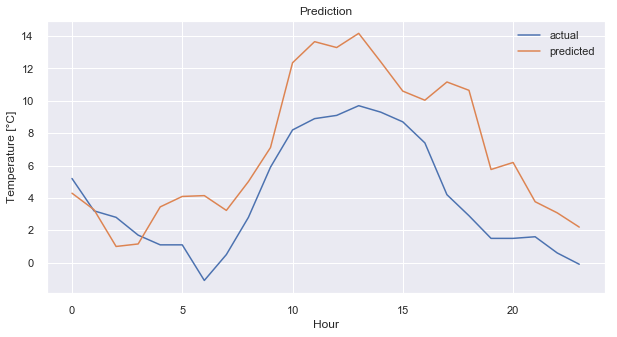

In [195]:
prediction_plot(Y_test, Y_pred)

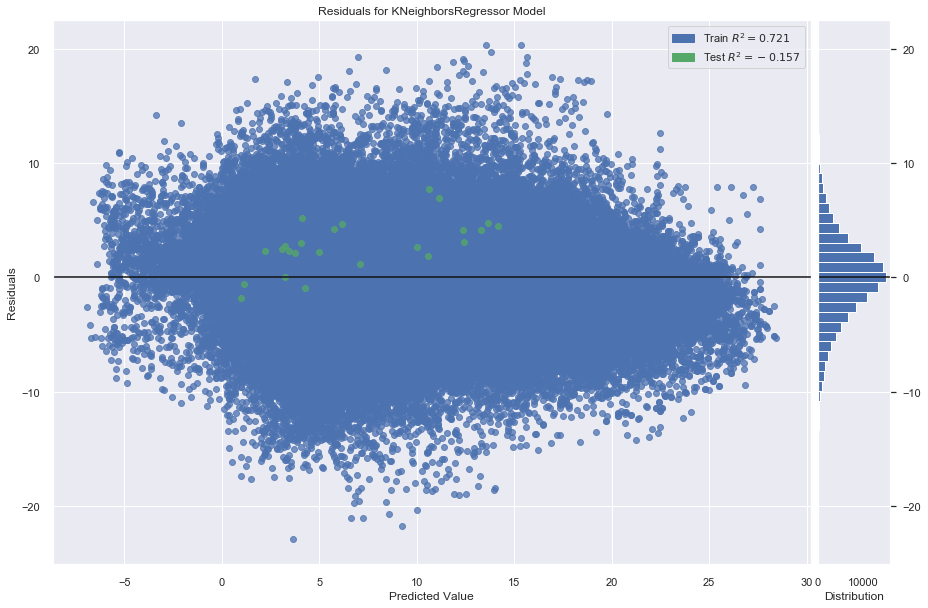

In [198]:
visualizer = ResidualsPlot(knr, size=(1080,720))
visualizer.fit(X_train, Y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, Y_test)  # Evaluate the model on the test data
visualizer.show();

In [196]:
# Metrics
mae0 = mean_absolute_error(Y_test.values.ravel(), Y_pred)
rmse0 = np.sqrt(mean_squared_error(Y_test.values.ravel(), Y_pred))
r2 = r2_score(Y_test.values.ravel(), Y_pred)

# Print metrics
print('Mean Absolute Error:', round(mae0, 2))
print('RMSE:', round(rmse0, 2))
print('R2:', round(r2, 2))

Mean Absolute Error: 3.16
RMSE: 3.67
R2: -0.16


## Support Vector Regressor

In [ ]:
# take a lot of time
from sklearn.svm import SVR
clf = SVR(kernel='poly', degree=3, C=1.0, gamma='auto', epsilon=0.2)
Y_pred = clf.fit(X_train, Y_train).predict(X_test)


//anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [ ]:
## Trying out different kernels

# #############################################################################
# Fit regression model
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_lin = SVR(kernel='linear', C=100, gamma='auto')
svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1,
               coef0=1)

# #############################################################################
# Look at the results
lw = 2

svrs = [svr_rbf, svr_lin, svr_poly]
kernel_label = ['RBF', 'Linear', 'Polynomial']
model_color = ['m', 'c', 'g']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10), sharey=True)
for ix, svr in enumerate(svrs):
    axes[ix].plot(X, svr.fit(X, Y).predict(X), color=model_color[ix], lw=lw,
                  label='{} model'.format(kernel_label[ix]))
    axes[ix].scatter(X[svr.support_], Y[svr.support_], facecolor="none",
                     edgecolor=model_color[ix], s=50,
                     label='{} support vectors'.format(kernel_label[ix]))
    axes[ix].scatter(X[np.setdiff1d(np.arange(len(X)), svr.support_)],
                     Y[np.setdiff1d(np.arange(len(X)), svr.support_)],
                     facecolor="none", edgecolor="k", s=50,
                     label='other training data')
    axes[ix].legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
                    ncol=1, fancybox=True, shadow=True)

fig.text(0.5, 0.04, 'data', ha='center', va='center')
fig.text(0.06, 0.5, 'target', ha='center', va='center', rotation='vertical')
fig.suptitle("Support Vector Regression", fontsize=14)
plt.show()

## Classification models for precipitation

In [199]:
## prepare dataset for classification by replacing precipitation values >0 mm with ones

df2_R1 = df.R1.where(df.R1 == 0, 1)
df2_R1 = pd.DataFrame(df2_R1)
df2 = df.drop(columns='R1')
df2 = pd.concat([df2_R1,df2],axis=1)
df2.head()

,R1,MESS_DATUM,ATMO_LBERG,FD_LBERG,FG_LBERG,SD_LBERG,ZENIT,TT_TU,RF_TU,TD,...,V_S1_HHS,P,FF,DD,V_TE005,V_TE010,V_TE020,V_TE050,V_TE100,V_VV
0,0.0,2005-01-01 00:01:00,120.0,0.0,0.0,0.0,148.86,4.7,95.0,4.0,...,90.0,1020.2,2.2,350.0,5.6,5.5,5.2,4.6,5.2,2000.0
1,1.0,2005-01-01 01:01:00,100.0,0.0,0.0,0.0,144.98,4.3,95.0,3.6,...,90.0,1020.5,1.5,310.0,5.3,5.4,5.2,4.6,5.1,3500.0
2,0.0,2005-01-01 02:01:00,89.0,0.0,0.0,0.0,138.39,3.1,96.0,2.5,...,30.0,1021.3,1.5,280.0,4.7,5.1,5.1,4.6,5.1,800.0
3,0.0,2005-01-01 06:01:00,113.0,0.0,0.0,0.0,104.08,2.0,98.0,1.7,...,60.0,1022.0,2.3,220.0,3.7,4.2,4.7,4.8,5.2,3500.0
4,0.0,2005-01-01 07:01:00,114.0,0.0,0.0,0.0,96.06,2.7,100.0,2.7,...,60.0,1021.8,2.8,210.0,3.6,4.0,4.5,4.7,5.2,4500.0


## XGBoost Classification

In [200]:
from xgboost import XGBClassifier
import time

In [201]:
y = df2.R1
x = df2.drop(columns=['R1','MESS_DATUM'])

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.25, random_state=0)

t = time.time()
model = XGBClassifier(n_estimators=1000,learning_rate=0.6)
model.fit(x_train, y_train)
y_pred_xgb=model.predict(x_test)
elapsed = time.time() - t
elapsed

84.7941210269928

In [202]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96     29690
         1.0       0.75      0.63      0.69      3920

    accuracy                           0.93     33610
   macro avg       0.85      0.80      0.83     33610
weighted avg       0.93      0.93      0.93     33610



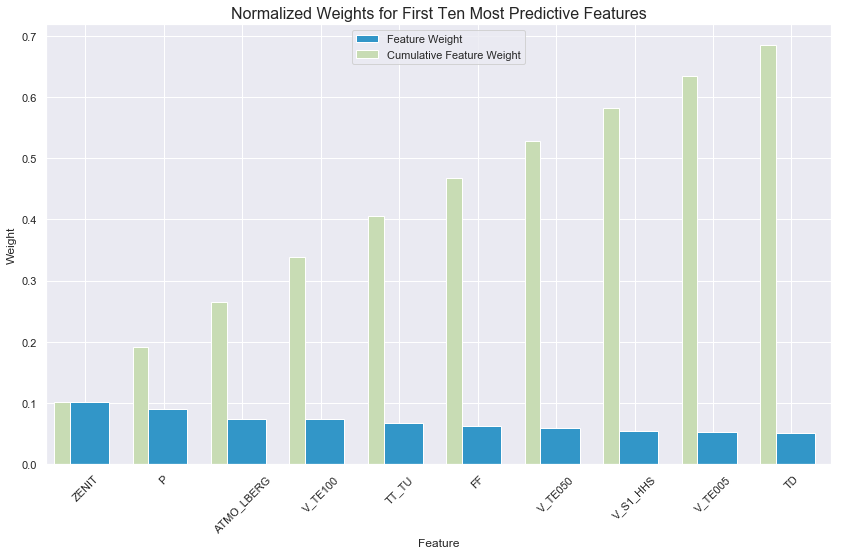

In [235]:
# Extract the feature importances
importances = model.feature_importances_

# Plot
feature_plot(importances, x_train, y_train)

Recall Baseline: 1.0 Test: 0.63 Train: 0.82
Precision Baseline: 0.12 Test: 0.75 Train: 0.91
Roc Baseline: 0.5 Test: 0.95 Train: 0.99


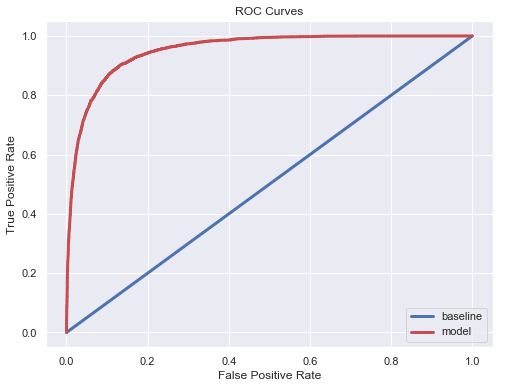

In [236]:
# Make probability predictions
train_probs = model.predict_proba(x_train)[:, 1]
probs = model.predict_proba(x_test)[:, 1]

train_predictions = model.predict(x_train)
predictions = model.predict(x_test)

train_labels = y_train.copy()
test_labels = y_test.copy()

evaluate_model(predictions, probs, train_predictions, train_probs)

In [237]:
from sklearn.metrics import roc_auc_score

train_probs = model.predict_proba(x_train)[:, 1]

roc_auc_score(y_train, train_probs)

0.9915294629818073

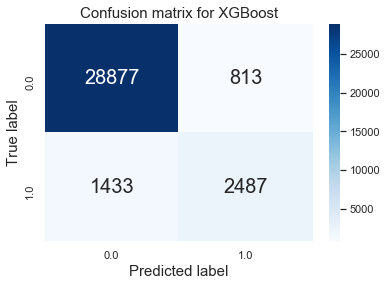

In [239]:
confusion_matrix = pd.crosstab(y_test, y_pred_xgb, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True,annot_kws={'size': 20},fmt='g',cmap='Blues');

plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.title('Confusion matrix for XGBoost', fontsize=15);

## AdaBoost Classifier

In [240]:
from xgboost import XGBClassifier

In [241]:
t = time.time()
ada = AdaBoostClassifier(n_estimators=1000,learning_rate=0.6)
ada.fit(x_train, y_train)
y_pred_ada=model.predict(x_test)
elapsed = time.time() - t
elapsed

99.9730761051178

In [242]:
print(classification_report(y_test, y_pred_ada))

              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96     29690
         1.0       0.75      0.63      0.69      3920

    accuracy                           0.93     33610
   macro avg       0.85      0.80      0.83     33610
weighted avg       0.93      0.93      0.93     33610



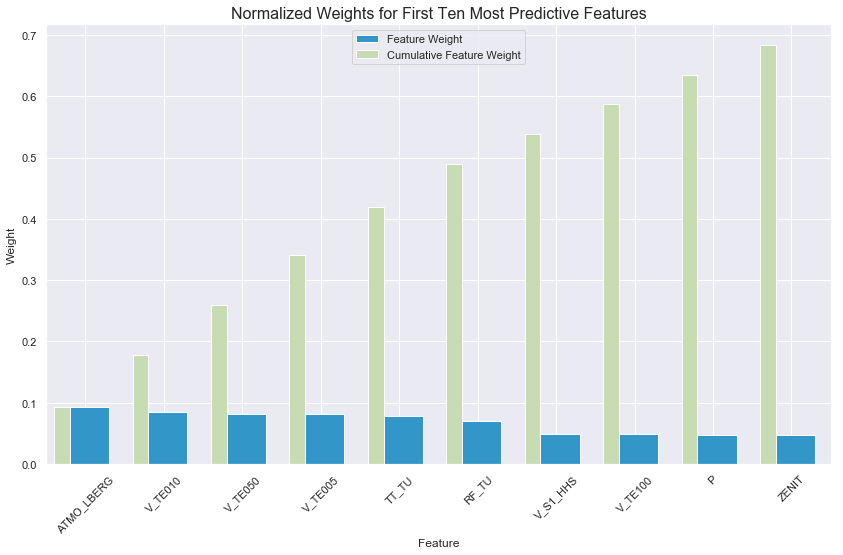

In [243]:
# Extract the feature importances
importances = ada.feature_importances_

# Plot
feature_plot(importances, x_train, y_train)

Recall Baseline: 1.0 Test: 0.46 Train: 0.46
Precision Baseline: 0.12 Test: 0.72 Train: 0.7
Roc Baseline: 0.5 Test: 0.93 Train: 0.93


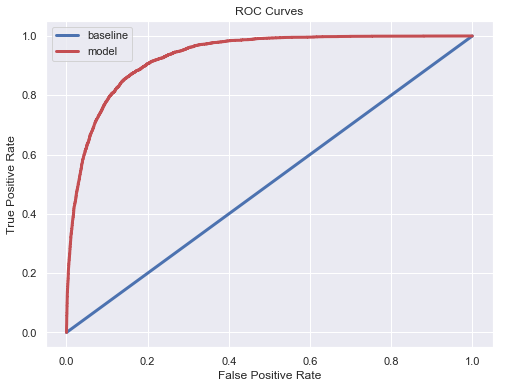

In [244]:
# Make probability predictions
train_probs = ada.predict_proba(x_train)[:, 1]
probs = ada.predict_proba(x_test)[:, 1]

train_predictions = ada.predict(x_train)
predictions = ada.predict(x_test)

train_labels = y_train.copy()
test_labels = y_test.copy()

evaluate_model(predictions, probs, train_predictions, train_probs)

In [246]:
## ROC score
roc_auc_score(y_train, train_probs)

0.9334227647238743

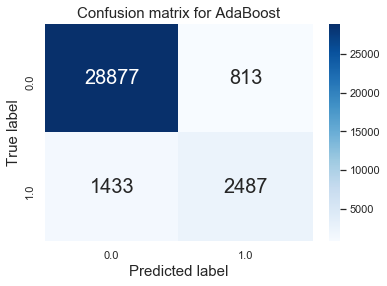

In [249]:
confusion_matrix = pd.crosstab(y_test, y_pred_ada, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True,annot_kws={'size': 20},fmt='g',cmap='Blues');

plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.title('Confusion matrix for AdaBoost', fontsize=15);

## Logistic Regression

In [264]:
t = time.time()

lr = LogisticRegression()
lr.fit(x_train, y_train)
y_pred_log=lr.predict(x_test)
elapsed = time.time() - t
elapsed

//anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1.6240668296813965

In [265]:
print(classification_report(y_test, y_pred_log))

              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95     29690
         1.0       0.69      0.35      0.46      3920

    accuracy                           0.91     33610
   macro avg       0.80      0.66      0.71     33610
weighted avg       0.89      0.91      0.89     33610



Recall Baseline: 1.0 Test: 0.35 Train: 0.34
Precision Baseline: 0.12 Test: 0.69 Train: 0.67
Roc Baseline: 0.5 Test: 0.91 Train: 0.91


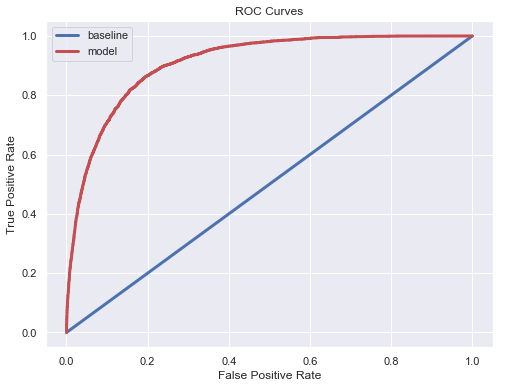

In [268]:
# Make probability predictions
train_probs = lr.predict_proba(x_train)[:, 1]
probs = lr.predict_proba(x_test)[:, 1]

train_predictions = lr.predict(x_train)
predictions = lr.predict(x_test)

train_labels = y_train.copy()
test_labels = y_test.copy()

evaluate_model(predictions, probs, train_predictions, train_probs)

In [269]:
## ROC score
roc_auc_score(y_test, probs)

0.9102339222991319

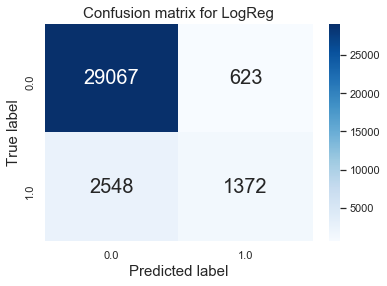

In [270]:
confusion_matrix = pd.crosstab(y_test, y_pred_log, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True,annot_kws={'size': 20},fmt='g',cmap='Blues');

plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.title('Confusion matrix for LogReg', fontsize=15);

## Gaussian Naive Bayes Classsifier

In [16]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
t = time.time()
y_pred_gnb = gnb.fit(x_train, y_train).predict(x_test)

elapsed = time.time() - t
elapsed

0.05295586585998535

In [17]:
print(classification_report(y_test, y_pred_gnb))

              precision    recall  f1-score   support

         0.0       0.98      0.67      0.79     29690
         1.0       0.26      0.88      0.40      3920

    accuracy                           0.69     33610
   macro avg       0.62      0.77      0.60     33610
weighted avg       0.89      0.69      0.75     33610



Recall Baseline: 1.0 Test: 0.88 Train: 0.88
Precision Baseline: 0.12 Test: 0.26 Train: 0.25
Roc Baseline: 0.5 Test: 0.86 Train: 0.86


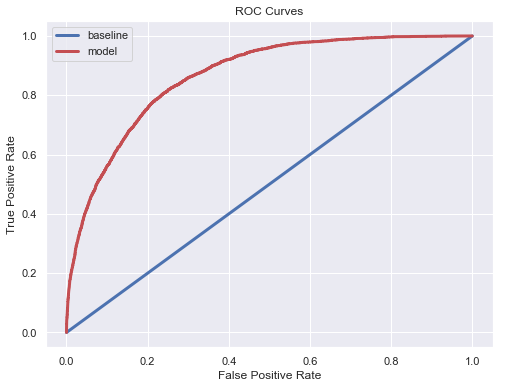

In [18]:
# Make probability predictions
train_probs = gnb.predict_proba(x_train)[:, 1]
probs = gnb.predict_proba(x_test)[:, 1]

train_predictions = gnb.predict(x_train)
predictions = gnb.predict(x_test)

train_labels = y_train.copy()
test_labels = y_test.copy()

evaluate_model(predictions, probs, train_predictions, train_probs)

In [19]:
## ROC score
roc_auc_score(y_test, probs)

0.8648143228325348

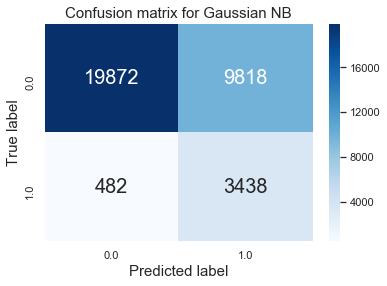

In [21]:
confusion_matrix = pd.crosstab(y_test, y_pred_gnb, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True,annot_kws={'size': 20},fmt='g',cmap='Blues');

plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.title('Confusion matrix for Gaussian NB', fontsize=15);

## RandomForest Classifier

In [251]:
t = time.time()
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(x_train, y_train)
y_pred_rf=rf.predict(x_test)
elapsed = time.time() - t
elapsed

174.56991004943848

In [252]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96     29690
         1.0       0.82      0.55      0.66      3920

    accuracy                           0.93     33610
   macro avg       0.88      0.77      0.81     33610
weighted avg       0.93      0.93      0.93     33610



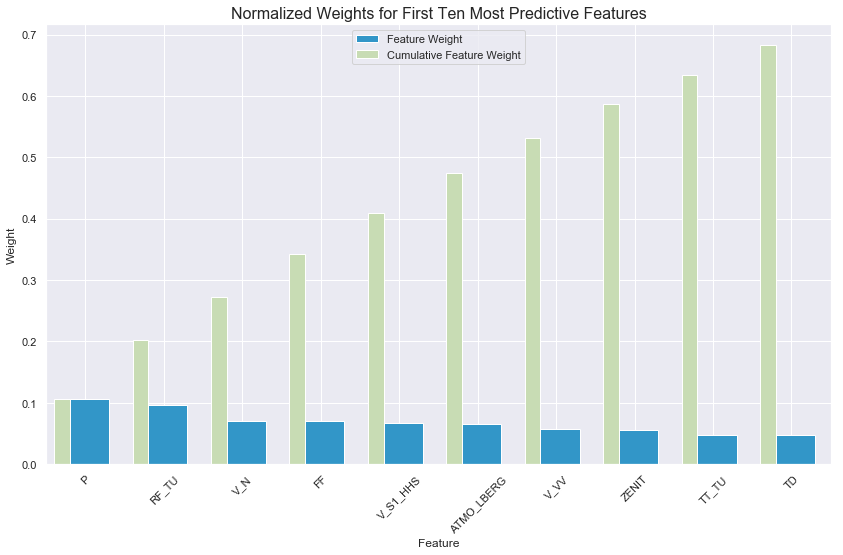

In [254]:
# Extract the feature importances
importances = rf.feature_importances_

# Plot
feature_plot(importances, x_train, y_train)

Recall Baseline: 1.0 Test: 0.55 Train: 1.0
Precision Baseline: 0.12 Test: 0.82 Train: 1.0
Roc Baseline: 0.5 Test: 0.96 Train: 1.0


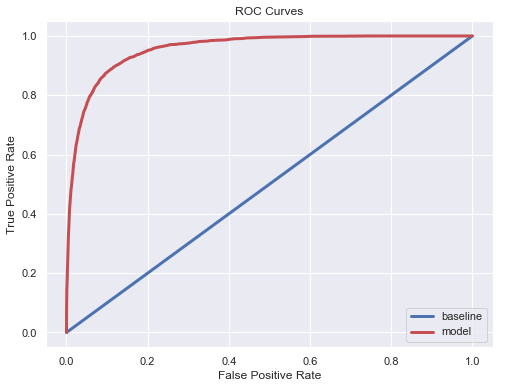

In [255]:
# Make probability predictions
train_probs = rf.predict_proba(x_train)[:, 1]
probs = rf.predict_proba(x_test)[:, 1]

train_predictions = rf.predict(x_train)
predictions = rf.predict(x_test)

train_labels = y_train.copy()
test_labels = y_test.copy()

evaluate_model(predictions, probs, train_predictions, train_probs)

In [257]:
## ROC score
roc_auc_score(y_test, probs)

0.9568349904798564

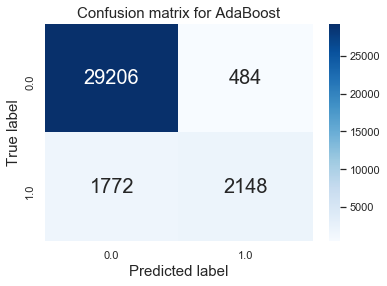

In [258]:
confusion_matrix = pd.crosstab(y_test, y_pred_rf, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True,annot_kws={'size': 20},fmt='g',cmap='Blues');

plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.title('Confusion matrix for RandomForest', fontsize=15);

## RandomForest Classifier with RandomizedGridSearch Cross-Validation

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = 0)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 10, verbose = 1, random_state=10)

# Fit
t = time.time()

rs.fit(x_train, y_train)

best_model = rs.best_estimator_
train_rf_predictions = best_model.predict(x_train)

train_rf_probs = best_model.predict_proba(x_train)[:, 1]

rf_predictions = best_model.predict(x_test)
rf_probs = best_model.predict_proba(x_test)[:, 1]

n_nodes = []
max_depths = []

for ind_tree in best_model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)

elapsed = time.time() - t
elapsed

In [ ]:
# Random Forest with best parameters

y = df_imputed.TARGET
x = df_imputed.drop(columns=['TARGET'])

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.25, random_state=10)

# Run random forest classifier
t = time.time()
random_forest = RandomForestClassifier(n_estimators=161,min_samples_split=5,max_leaf_nodes=41, max_features=0.5, max_depth=7,random_state = 10, verbose = 1, n_jobs = -1)
random_forest.fit(x_train, y_train)
y_pred = random_forest.predict(x_test)
elapsed = time.time() - t
elapsed

## Cross Valiadation

In [ ]:
def model_cross_valid(X,Y):
    seed = 7
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    def bulid_model(model_name):
        model = model_name()
        return model
    scoring = 'neg_mean_squared_error'
    # + random fest boost lstm gbdt

    for model_name in [LinearRegression,ElasticNet]:
    #for model_name in [LinearRegression,Ridge,Lasso,ElasticNet,KNeighborsRegressor,DecisionTreeRegressor,SVR,RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor]:
        model = bulid_model(model_name)
        results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
        print(model_name,results.mean()) 

## Auto Regressive Integrated Moving Average - ARIMA

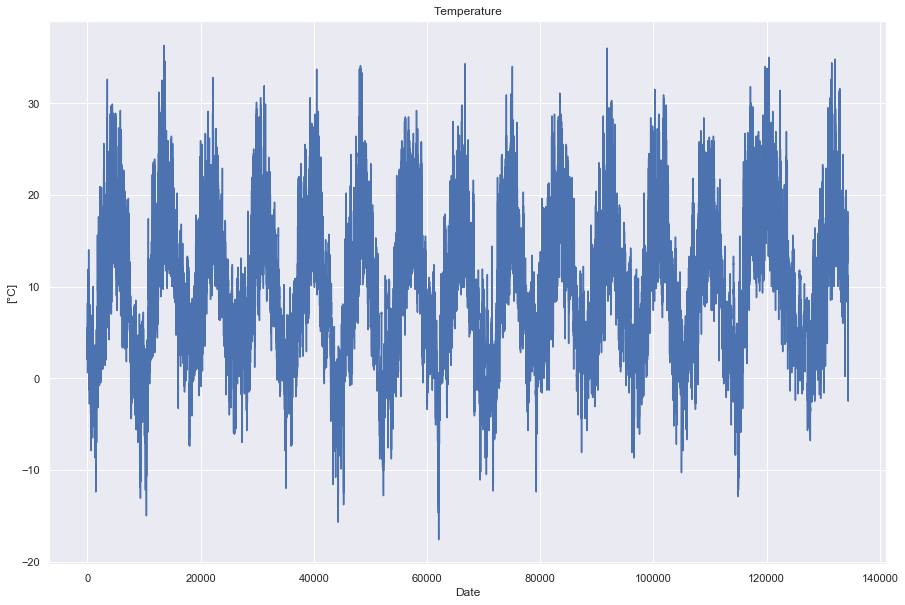

In [76]:
plt.figure(figsize=(15,10))
plt.plot(df.TT_TU)
plt.xlabel('Date')
plt.ylabel('[°C]')
plt.title('Temperature');


In [7]:
df_temp = pd.concat([df.MESS_DATUM,df.TT_TU],axis=1)
df_temp.set_index(['MESS_DATUM'],inplace=True)
df_temp.head()

,TT_TU
MESS_DATUM,
2005-01-01 00:01:00,4.7
2005-01-01 01:01:00,4.3
2005-01-01 02:01:00,3.1
2005-01-01 06:01:00,2.0
2005-01-01 07:01:00,2.7


In [8]:
# Determine rolling statistics
rolmean = df_temp.rolling(window=720).mean() #window size 720 denotes 1 month, giving rolling mean at yearly level
rolstd = df_temp.rolling(window=720).std()
# print(rolmean,rolstd)

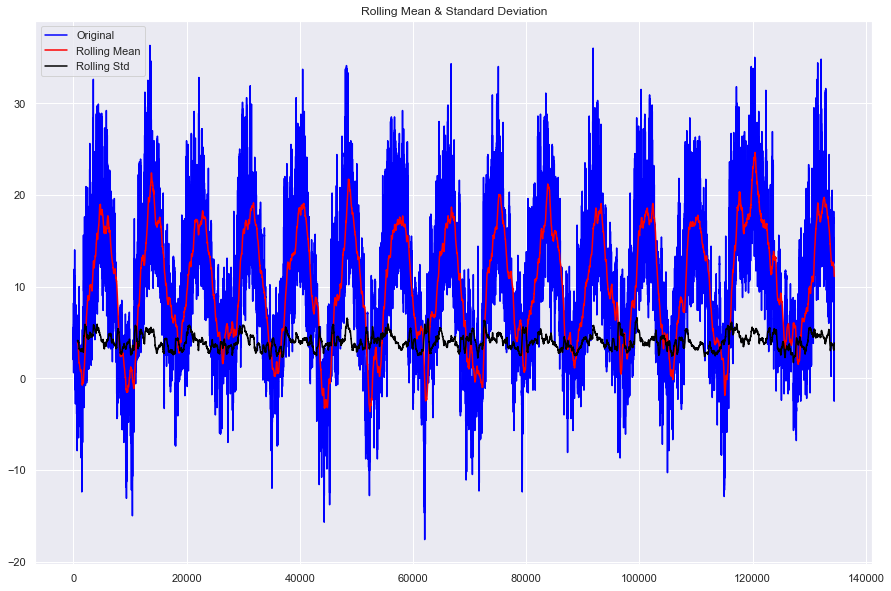

In [13]:
# Plot rolling statistics
plt.figure(figsize=(15,10))
plt.plot(df.TT_TU, color='blue', label='Original')
plt.plot(rolmean.values, color='red', label='Rolling Mean')
plt.plot(rolstd.values, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [14]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams


# Perform Augmented Dickey–Fuller test:

print('Results of Dickey Fuller Test:')
dftest = adfuller(df_temp.iloc[:,0].values, autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                -1.145992e+01
p-value                        5.587114e-21
#Lags Used                     7.300000e+01
Number of Observations Used    1.343630e+05
Critical Value (1%)           -3.430399e+00
Critical Value (5%)           -2.861562e+00
Critical Value (10%)          -2.566781e+00
dtype: float64


In [ ]:
#For a Time series to be stationary, its ADCF test should have:

# p-value to be low (according to the null hypothesis)  ---> accomplished
# The critical values at 1%, 5%, 10% confidence intervals should be as close as possible to the Test Statistics!
## The dataset is stationary!

## For non stationary dataset there are diffenent ways to achieve stationary: transformation with log, 
## exponential decay and time shift

Plotting ARIMA model


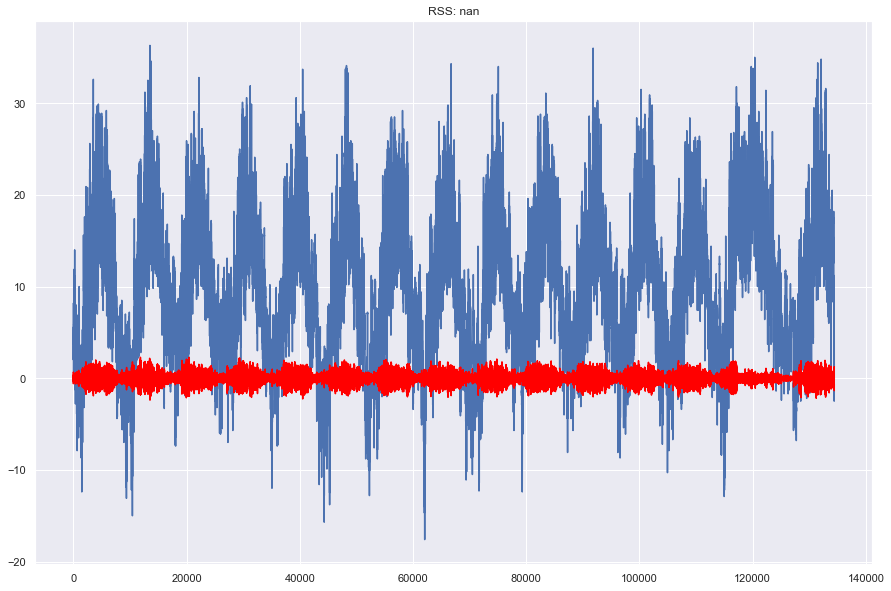

In [58]:
model = ARIMA(df.TT_TU, order=(2,1,2))
results_ARIMA = model.fit(disp=-1)
plt.figure(figsize=(15,10))
plt.plot(df.TT_TU)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - df.TT_TU)**2))
print('Plotting ARIMA model')


In [ ]:
#predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
#print(predictions_ARIMA_diff.head())

In [ ]:
#predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
#print(predictions_ARIMA_diff_cumsum)

In [ ]:
#predictions_ARIMA_log = pd.Series(indexedDataset_logScale['#Passengers'].iloc[0], index=indexedDataset_logScale.index)
#predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
#predictions_ARIMA_log.head()

<Figure size 1440x1080 with 0 Axes>

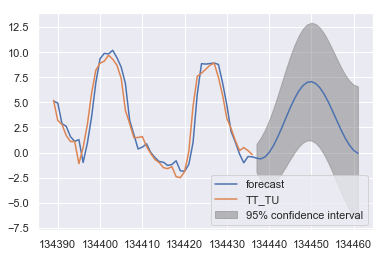

In [72]:
#We have 144(existing data of 12 yrs in months) data points. 
#And we want to forecast for additional 120 data points or 10 yrs.

plt.figure(figsize=(20,15))
#results_ARIMA.plot_predict(len(df.TT_TU)-24,len(df.TT_TU)+24)
results_ARIMA.plot_predict(len(df.TT_TU)-48,len(df.TT_TU)+24)
plt.show();
#x=results_ARIMA.forecast(steps=24)

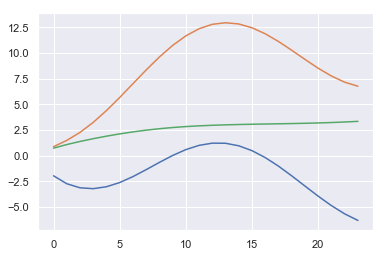

In [42]:
plt.plot(x[2])
plt.plot(x[1])

//anaconda3/envs/nf/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
//anaconda3/envs/nf/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
//anaconda3/envs/nf/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpr

                             ARIMA Model Results                              
Dep. Variable:                D.TT_TU   No. Observations:               134436
Model:                 ARIMA(5, 1, 0)   Log Likelihood             -155155.307
Method:                       css-mle   S.D. of innovations              0.767
Date:                Mon, 16 Dec 2019   AIC                         310324.614
Time:                        15:51:40   BIC                         310393.276
Sample:                             1   HQIC                        310345.178
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -4.581e-05      0.005     -0.010      0.992      -0.009       0.009
ar.L1.D.TT_TU     0.3782      0.003    139.276      0.000       0.373       0.383
ar.L2.D.TT_TU     0.2183      0.003     

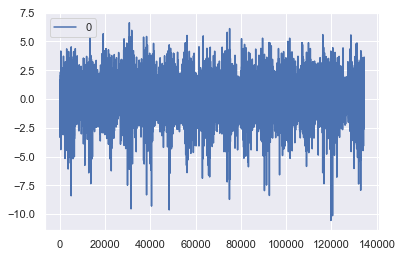

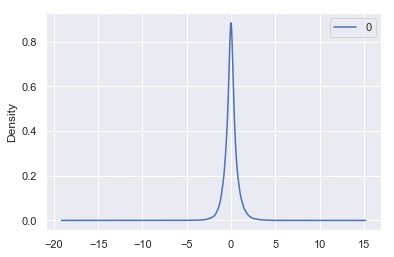

                   0
count  134436.000000
mean        0.000004
std         0.767348
min       -10.549722
25%        -0.350320
50%        -0.006669
75%         0.331658
max         6.628998


In [124]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(df.TT_TU, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

## Target variable: WINDSPEED

In [37]:
best_corr2 = corr.FF[abs(corr.FF) > 0.1]
best_corr2

FD_LBERG    0.195860
FG_LBERG    0.166519
ZENIT      -0.171639
RF_TU      -0.256106
V_N         0.198630
V_S1_CS     0.163650
V_S1_HHS   -0.168051
P          -0.284232
FF          1.000000
DD          0.101409
V_TE020    -0.136243
V_TE050    -0.157279
V_TE100    -0.150711
Name: FF, dtype: float64

In [38]:
## Linear Regression for windspeed
FD_LBERG + FG_LBERG + ZENIT + RF_TU + C(V_N) + P
model = 'FF ~ '
smf.ols(formula=model, data=df).fit().summary()

## bad prediction

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     FF   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     3002.
Date:                Fri, 13 Dec 2019   Prob (F-statistic):               0.00
Time:                        11:25:27   Log-Likelihood:            -2.7743e+05
No. Observations:              134437   AIC:                         5.549e+05
Df Residuals:                  134423   BIC:                         5.550e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        66.7185      0.571    116.840      0.000      65.599      67.838
C(V_N)[T.1.0]     0.0288      0.029      0.997      0.319      -0.028       0.085
C(V_N)[T.2.0]     0.2163      0.030      7.096      0.000       0.157       0.276
C(V_N)[T.3.0]     0.3550      0.031     11.591      0.000       0.295       0.415
C(V_N)[T.4.0]     0.4939      0.032     15.315      0.000       0.431       0.557
C(V_N)[T.5.0]     0.5171      0.031     16.713      0.000       0.456       0.578
C(V_N)[T.6.0]     0.6876      0.029     23.313      0.000       0.630       0.745
C(V_N)[T.7.0]     0.9366      0.025     36.835      0.000       0.887       0.986
C(V_N)[T.8.0]     1.6414      0.026     64.112      0.000       1.591       1.692
FD_LBERG          0.0066      0.000     20.024      0.000       0.006       0.007
FG_LBERG      -6.816e-05      0.000     -0.437      0.662      -0.000       0.000
ZENIT             0.0048      0.000     16.398      0.000       0.004       0.005
RF_TU            -0.0504      0.000   -114.049      0.000      -0.051      -0.049
P                -0.0592      0.001   -106.317      0.000      -0.060      -0.058
==============================================================================
Omnibus:                     5648.967   Durbin-Watson:                   0.263
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6516.957
Skew:                           0.499   Prob(JB):                         0.00
Kurtosis:                       3.411   Cond. No.                     1.12e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.12e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [139]:
X = df[['FD_LBERG','FG_LBERG','ZENIT','RF_TU','V_N','P']]
Y = df.FF


In [143]:


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 24/df.shape[0], random_state=0)
performance_windspeed1 = []
performance_windspeed2 = []
for i in range(1,7,1):
    
    poly_features = PolynomialFeatures(degree=i)
  
  # transforms the existing features to higher degree features.
    X_train_poly = poly_features.fit_transform(X_train)
  
  # fit the transformed features to Linear Regression
    poly_model = LinearRegression()
    poly_model.fit(X_train_poly, Y_train)
  
  # predicting on training data-set
    y_train_predicted = poly_model.predict(X_train_poly)
  
  # predicting on test data-set
    y_test_predict = poly_model.predict(poly_features.fit_transform(X_test))
  
  # evaluating the model on training dataset
    rmse_train = np.sqrt(mean_squared_error(Y_train, y_train_predicted))
    r2_train = r2_score(Y_train, y_train_predicted)
  
  # evaluating the model on test dataset
    rmse_test = np.sqrt(mean_squared_error(Y_test, y_test_predict))
    r2_test = r2_score(Y_test, y_test_predict)
    performance_windspeed1.append(r2_test)
    performance_windspeed2.append(rmse_test)
    print("Degree: {}".format(i),"R2 {}".format(performance_windspeed1[-1]), "RMSE {}".format(performance_windspeed2[-1]))

Degree: 1 R2 0.14888391027793646 RMSE 2.1860928771368298
Degree: 2 R2 0.24683906347865148 RMSE 2.0564497520865097
Degree: 3 R2 0.26569966159543856 RMSE 2.030537774056875
Degree: 4 R2 0.3469231706863487 RMSE 1.9149451841911176
Degree: 5 R2 0.3509184486769903 RMSE 1.9090787416714288
Degree: 6 R2 0.3690189039659503 RMSE 1.8822720047055554


## Target variable: PRECIPITATION

In [39]:
best_corr3 = corr.R1[abs(corr.R1) > 0.1]
best_corr3 

ATMO_LBERG    0.131764
R1            1.000000
RF_TU         0.146747
V_N           0.145535
P            -0.155392
V_VV         -0.154351
Name: R1, dtype: float64

In [40]:
## Linear Regression for precipitation

model = 'R1 ~ ATMO_LBERG + RF_TU + C(V_N) + P + V_VV'
smf.ols(formula=model, data=df).fit().summary()

## no prediction

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     R1   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     773.0
Date:                Fri, 13 Dec 2019   Prob (F-statistic):               0.00
Time:                        11:25:27   Log-Likelihood:                -86440.
No. Observations:              134437   AIC:                         1.729e+05
Df Residuals:                  134424   BIC:                         1.730e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         5.3792      0.141     38.132      0.000       5.103       5.656
C(V_N)[T.1.0]    -0.0098      0.007     -1.418      0.156      -0.023       0.004
C(V_N)[T.2.0]    -0.0278      0.007     -3.784      0.000      -0.042      -0.013
C(V_N)[T.3.0]    -0.0284      0.007     -3.843      0.000      -0.043      -0.014
C(V_N)[T.4.0]    -0.0359      0.008     -4.608      0.000      -0.051      -0.021
C(V_N)[T.5.0]    -0.0329      0.007     -4.401      0.000      -0.048      -0.018
C(V_N)[T.6.0]    -0.0406      0.007     -5.713      0.000      -0.055      -0.027
C(V_N)[T.7.0]    -0.0453      0.006     -7.260      0.000      -0.058      -0.033
C(V_N)[T.8.0]     0.0699      0.007     10.562      0.000       0.057       0.083
ATMO_LBERG        0.0028   8.93e-05     31.012      0.000       0.003       0.003
RF_TU             0.0024      0.000     23.059      0.000       0.002       0.003
P                -0.0057      0.000    -41.850      0.000      -0.006      -0.005
V_VV          -1.391e-06   1.26e-07    -11.011      0.000   -1.64e-06   -1.14e-06
==============================================================================
Omnibus:                   295038.252   Durbin-Watson:                   1.291
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       4731775907.727
Skew:                          19.690   Prob(JB):                         0.00
Kurtosis:                     921.247   Cond. No.                     3.09e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.09e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Target variale: PRESSURE

In [41]:
best_corr4 = corr.P[abs(corr.P) > 0.1]
best_corr4

ATMO_LBERG   -0.210408
SD_LBERG      0.147307
R1           -0.155392
RF_TU        -0.109709
TD           -0.119820
V_N          -0.255834
V_S1_HHS      0.147006
P             1.000000
FF           -0.284232
Name: P, dtype: float64

In [42]:
## Linear Regression for pressure

model = 'P ~ ATMO_LBERG + SD_LBERG + R1 + RF_TU + TD + C(V_N) + V_S1_HHS + FF'
smf.ols(formula=model, data=df).fit().summary()

## bad prediction

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      P   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     1896.
Date:                Fri, 13 Dec 2019   Prob (F-statistic):               0.00
Time:                        11:25:28   Log-Likelihood:            -4.8302e+05
No. Observations:              134437   AIC:                         9.661e+05
Df Residuals:                  134421   BIC:                         9.662e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1035.5335      0.348   2975.706      0.000    1034.851    1036.216
C(V_N)[T.1.0]    -2.6815      0.144    -18.629      0.000      -2.964      -2.399
C(V_N)[T.2.0]    -3.4503      0.148    -23.320      0.000      -3.740      -3.160
C(V_N)[T.3.0]    -3.8461      0.146    -26.270      0.000      -4.133      -3.559
C(V_N)[T.4.0]    -4.1496      0.153    -27.198      0.000      -4.449      -3.851
C(V_N)[T.5.0]    -4.3041      0.147    -29.328      0.000      -4.592      -4.016
C(V_N)[T.6.0]    -4.4781      0.139    -32.173      0.000      -4.751      -4.205
C(V_N)[T.7.0]    -4.1744      0.123    -33.946      0.000      -4.415      -3.933
C(V_N)[T.8.0]    -3.5097      0.131    -26.873      0.000      -3.766      -3.254
ATMO_LBERG       -0.0485      0.002    -19.572      0.000      -0.053      -0.044
SD_LBERG          0.0401      0.002     25.531      0.000       0.037       0.043
R1               -1.8023      0.052    -34.657      0.000      -1.904      -1.700
RF_TU            -0.0730      0.002    -34.563      0.000      -0.077      -0.069
TD               -0.1304      0.006    -22.311      0.000      -0.142      -0.119
V_S1_HHS          0.0002   1.26e-05     12.923      0.000       0.000       0.000
FF               -1.3169      0.012   -106.463      0.000      -1.341      -1.293
==============================================================================
Omnibus:                     3634.148   Durbin-Watson:                   0.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5165.795
Skew:                          -0.298   Prob(JB):                         0.00
Kurtosis:                       3.752   Cond. No.                     4.13e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.13e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [169]:
y

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

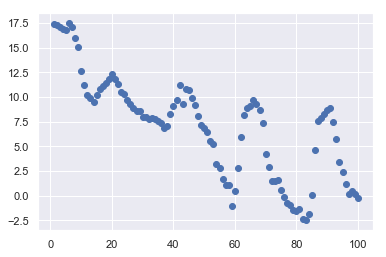

In [171]:
y=np.arange(1,len(df.TT_TU[-100:])+1,1)
plt.scatter(y,df.TT_TU[-100:])